<a href="https://colab.research.google.com/github/mhisle22/DSC-Covid-and-Census/blob/master/dsc305_covid_and_census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mark Hisle  
DSC 305  
Predicting Covid19 with the US Census Data

#Outline

This is an exploratory project aimed at using US Census data from 2017 to make observations on the spread of the novel virus COVID19 in the year 2020. Data is collected and processed from two different sources, both of which were taken from Kaggle: US Census Demographic Data, containing standard census data on US counties, and US counties COVID 19 dataset, a dataset taken from the New York Time's report on the number of cases and deaths caused by the virus in US counties since the first reports of cases in Washington state. All counties in the United States are accounted for, including data for Washington D.C. Links to the two datasets can be found below.

This project seeks to answer a few common questions on the spread of this virus using basic geographical data: 
* Are more populous counties more significantly affected?
* Is there a trend between the overall poverty/wealth of a country and its number of cases? This can be viewed with a number of variables taken from the census, such as poverty rate, income per capita, etc.
* Are certain states proportinoally more affected than others (i.e.- has the number of cases largely followed population, or are the preventative measures of certain state governments cause noticeable improvements? Are other factors involved (coastal, climate, border state, etc.))
* Is there a difference between men and women?
* Are counties with a higher proportion of commuters/work from home/walkers/transit users more affected?
* Does unemployement have a large affect on number of cases?
* Does the US classification of ethnicity (non-Hispanic white, Hispanic, Black, Asian, Native, Pacific Islander) cause noticeable differences?
* What trends can be observed over certain time periods

By aggregating, visualizing, and building several different statistical models with this data, we hope to give a general insight on whether Census data can be used to make predictions on the spread of this virus. 

At the time of the creation of this project (Spring 2020), data for the spread of the virus is still developing, as the COVID19 virus was still widespread within the country at the time. Because of this, the NYT US County COVID19 dataset continually gained new information. It is highly possible in the future that the virus will no longer be active in the US, and this data will no longer be in flux. In addition to this, assuming the virus will start to dissappear, completely new trends will appear later on, which will need separate analyses focusing on this new data.    
 
  
https://www.kaggle.com/muonneutrino/us-census-demographic-data   
https://www.kaggle.com/fireballbyedimyrnmom/us-counties-covid-19-dataset



In [0]:
import numpy as np
import pandas as pd
from sklearn import metrics #for visualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from yellowbrick.target import FeatureCorrelation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import itertools
import datetime
import pytz



%matplotlib inline

#Data Observation

In [112]:
from google.colab import files
import io

#locally upload the census data file
uploaded = files.upload() 

census = pd.read_csv(io.BytesIO(uploaded["acs2017_county_data.csv"]))
pd.set_option('display.max_columns', None) #necessary to handle huge amount of columns
census

Saving acs2017_county_data.csv to acs2017_county_data (2).csv


,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja Municipio,54754,26269,28485,96.7,3.1,0.1,0.0,0.0,0.0,42838,18900,1219,10197,576,43.8,49.4,28.6,20.2,25.9,11.1,14.2,92.0,4.2,0.9,1.4,0.6,0.9,31.6,14234,76.2,19.3,4.3,0.2,16.8
3216,72147,Puerto Rico,Vieques Municipio,8931,4351,4580,95.7,4.0,0.0,0.0,0.0,0.0,7045,16261,2414,11136,1459,36.8,68.2,20.9,38.4,16.4,16.9,7.3,76.3,16.9,0.0,5.0,0.0,1.7,14.9,2927,40.7,40.9,18.4,0.0,12.8
3217,72149,Puerto Rico,Villalba Municipio,23659,11510,12149,99.7,0.2,0.1,0.0,0.0,0.0,18053,19893,1935,10449,1619,50.0,67.9,22.5,21.2,22.7,14.1,19.5,83.1,11.8,0.1,2.1,0.0,2.8,28.4,6873,59.2,30.2,10.4,0.2,24.8
3218,72151,Puerto Rico,Yabucoa Municipio,35025,16984,18041,99.9,0.1,0.0,0.0,0.0,0.0,27523,15586,1467,8672,702,52.4,62.1,27.7,26.0,20.7,9.5,16.0,87.6,9.2,0.0,1.4,1.8,0.1,30.5,7878,62.7,30.9,6.3,0.0,25.4


First off, we have the US Census data taken from a local file. Although the actual metrics that the Census is measuring change on a daily basis, we will only be using data from 2017 for the purpose of this project. In this dataframe, we have a variety of useful data that people often cite concerning the spread of the virus, such as county population, ethnicity statistics, and poverty rate.

In [113]:
covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
covid.tail(50)

,date,county,state,fips,cases,deaths
72938,2020-04-19,Milwaukee,Wisconsin,55079.0,2150,125
72939,2020-04-19,Monroe,Wisconsin,55081.0,13,0
72940,2020-04-19,Oconto,Wisconsin,55083.0,4,0
72941,2020-04-19,Oneida,Wisconsin,55085.0,6,0
72942,2020-04-19,Outagamie,Wisconsin,55087.0,35,2
72943,2020-04-19,Ozaukee,Wisconsin,55089.0,79,9
72944,2020-04-19,Pierce,Wisconsin,55093.0,7,0
72945,2020-04-19,Polk,Wisconsin,55095.0,4,0
72946,2020-04-19,Portage,Wisconsin,55097.0,4,0
72947,2020-04-19,Price,Wisconsin,55099.0,1,0


The COVID19 virus case data is taken from the New York Time's Github repository concerning the subject. This data is being updated on a daily basis at the time of this project, so logically it would make sense to frequently reload the data for this dataset. Here, the data is listed as follows: the date in which the certain point was collected, the county and State it represents, an FIPS id representing which US metro areas the county belongs to, and lastly, data for the number of cases and deaths in that county at the time.  

Now all that's left is to clean up the data a little, then merge the two sets together on their county data, then we will be ready to start creating models.


#Data Preparation



##Starting, Uncleaned Datasets

In [114]:
#remove all instances of the word county in the county column
census['County'] = census['County'].str.replace(' County', '').values
#likewise, Louisiana is special and lists counties as parishes
#They can't be doin' that
census['County'] = census['County'].str.replace(' Parish', '').values

#Puerto Rico is being dropped as the COVID df has no county data for it
#It also is a more unique region that would require separate analysis outside the scope of this project
census = census[census.State != 'Puerto Rico']

#dropping a few columns that will not be used in this project
census = census.drop(columns=['CountyId', 'VotingAgeCitizen', 'IncomeErr', 'IncomePerCapErr', 'Professional', 'Service', 'Office', 'Construction', 'Production',
                              'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Employed'])
census

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,ChildPoverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,Alabama,Autauga,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,55317,27824,13.7,20.1,86.0,9.6,0.1,0.6,1.3,2.5,25.8,5.2
1,Alabama,Baldwin,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,52562,29364,11.8,16.1,84.7,7.6,0.1,0.8,1.1,5.6,27.0,5.5
2,Alabama,Barbour,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,33368,17561,27.2,44.9,83.4,11.1,0.3,2.2,1.7,1.3,23.4,12.4
3,Alabama,Bibb,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,43404,20911,15.2,26.6,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8.2
4,Alabama,Blount,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,47412,22021,15.6,25.4,86.8,10.2,0.1,0.4,0.4,2.1,35.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,Sweetwater,44527,22981,21546,16.0,79.6,0.8,0.6,0.6,0.5,71083,31700,12.0,15.7,77.5,14.4,2.6,2.8,1.3,1.5,20.5,5.2
3138,Wyoming,Teton,22923,12169,10754,15.0,81.5,0.5,0.3,2.2,0.0,80049,49200,6.8,2.8,68.3,6.7,3.8,11.7,3.8,5.7,14.3,1.3
3139,Wyoming,Uinta,20758,10593,10165,9.1,87.7,0.1,0.9,0.1,0.0,54672,27115,14.9,20.0,77.4,14.9,3.3,1.1,1.3,2.0,19.9,6.4
3140,Wyoming,Washakie,8253,4118,4135,14.2,82.2,0.3,0.4,0.1,0.0,51362,27345,12.8,17.5,77.2,10.2,0.0,6.9,1.3,4.4,14.3,6.1


In [115]:
#check if any columns have missing or duplicate data, then fix
census.isna().any()
#ChildPoverty is missing data, which is fine since Poverty will suffice
census = census.drop(columns=['ChildPoverty'])

census[census.duplicated(keep='last')]
#no duplicates, thankfully
census

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,Alabama,Autauga,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,55317,27824,13.7,86.0,9.6,0.1,0.6,1.3,2.5,25.8,5.2
1,Alabama,Baldwin,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,52562,29364,11.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,5.5
2,Alabama,Barbour,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,33368,17561,27.2,83.4,11.1,0.3,2.2,1.7,1.3,23.4,12.4
3,Alabama,Bibb,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,43404,20911,15.2,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8.2
4,Alabama,Blount,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,47412,22021,15.6,86.8,10.2,0.1,0.4,0.4,2.1,35.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,Sweetwater,44527,22981,21546,16.0,79.6,0.8,0.6,0.6,0.5,71083,31700,12.0,77.5,14.4,2.6,2.8,1.3,1.5,20.5,5.2
3138,Wyoming,Teton,22923,12169,10754,15.0,81.5,0.5,0.3,2.2,0.0,80049,49200,6.8,68.3,6.7,3.8,11.7,3.8,5.7,14.3,1.3
3139,Wyoming,Uinta,20758,10593,10165,9.1,87.7,0.1,0.9,0.1,0.0,54672,27115,14.9,77.4,14.9,3.3,1.1,1.3,2.0,19.9,6.4
3140,Wyoming,Washakie,8253,4118,4135,14.2,82.2,0.3,0.4,0.1,0.0,51362,27345,12.8,77.2,10.2,0.0,6.9,1.3,4.4,14.3,6.1


In [116]:
#Now to fix up covid, mostly in the same way
#drop Puerto Rico
covid = covid[covid.state != 'Puerto Rico']

#drop  Northern Mariana Islands since there is very little data on this region
covid = covid[covid.state != 'Northern Mariana Islands']

covid.groupby('state').count() #check all states

#check if any columns have missing or duplicate data, then fix
covid.isna().any()

covid[covid.duplicated(keep='last')]
#no duplicates again

#all that's left is to rename some columns so they match Census
covid.columns = ['Date', 'County', 'State', 'fips', 'Cases', 'Deaths']
covid

,Date,County,State,fips,Cases,Deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...
72983,2020-04-19,Sublette,Wyoming,56035.0,1,0
72984,2020-04-19,Sweetwater,Wyoming,56037.0,10,0
72985,2020-04-19,Teton,Wyoming,56039.0,62,0
72986,2020-04-19,Uinta,Wyoming,56041.0,6,0


In [117]:
#there are some COVID cases where the location of the patient is unknown- check these
covid[covid.County == 'Unknown']

,Date,County,State,fips,Cases,Deaths
418,2020-03-01,Unknown,Rhode Island,NaN,2,0
450,2020-03-02,Unknown,Rhode Island,NaN,2,0
485,2020-03-03,Unknown,Rhode Island,NaN,2,0
522,2020-03-04,Unknown,Rhode Island,NaN,2,0
569,2020-03-05,Unknown,Rhode Island,NaN,2,0
...,...,...,...,...,...,...
72668,2020-04-19,Unknown,Utah,NaN,0,1
72684,2020-04-19,Unknown,Vermont,NaN,10,0
72688,2020-04-19,Unknown,Virgin Islands,NaN,51,2
72804,2020-04-19,Unknown,Virginia,NaN,2,89


##Merged Dataset

In [118]:
#Merge the two datasets on county
covid2 = covid.merge(census, on=['State', 'County'], how='outer')
covid2[covid2.State == 'Wyoming'].tail(50)
covid2

,Date,County,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,2020-01-21,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
1,2020-01-22,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
2,2020-01-23,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
3,2020-01-24,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
4,2020-01-25,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73310,NaN,Pepin,Wisconsin,NaN,NaN,NaN,7282.0,3701.0,3581.0,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4
73311,NaN,Taylor,Wisconsin,NaN,NaN,NaN,20344.0,10402.0,9942.0,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8
73312,NaN,Vernon,Wisconsin,NaN,NaN,NaN,30378.0,15240.0,15138.0,1.6,96.3,0.4,0.3,0.5,0.0,49996.0,25314.0,16.6,78.4,7.2,0.6,3.8,2.5,7.5,24.5,2.9
73313,NaN,Platte,Wyoming,NaN,NaN,NaN,8703.0,4535.0,4168.0,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5


In [119]:
#Some counties have no cases (THIS MAY CHANGE IN THE FUTURE.)
#Replace their dates with yesterday, cases and deaths with 0

#and then date has to be special

#localize today first, datetime is flawed
today = datetime.datetime.now(tz=pytz.timezone('US/Eastern')).date() #I spent way too much time trying to fix this, so don't ask
yesterday = today - datetime.timedelta(days=1)

#setup how columns should be changed
values = {'fips': 0, 'Cases': 0, 'Deaths': 0, 'Date': yesterday}

covid2.fillna(value=values, inplace=True) 
covid2

,Date,County,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,2020-01-21,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
1,2020-01-22,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
2,2020-01-23,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
3,2020-01-24,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
4,2020-01-25,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73310,2020-04-19,Pepin,Wisconsin,0.0,0.0,0.0,7282.0,3701.0,3581.0,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4
73311,2020-04-19,Taylor,Wisconsin,0.0,0.0,0.0,20344.0,10402.0,9942.0,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8
73312,2020-04-19,Vernon,Wisconsin,0.0,0.0,0.0,30378.0,15240.0,15138.0,1.6,96.3,0.4,0.3,0.5,0.0,49996.0,25314.0,16.6,78.4,7.2,0.6,3.8,2.5,7.5,24.5,2.9
73313,2020-04-19,Platte,Wyoming,0.0,0.0,0.0,8703.0,4535.0,4168.0,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5


In [120]:
#check one last time for any issues in the data
covid2.isna().any()

#there are "Unknown" counties, let's separate these out and hold on to them for later
#if needed they can easily be appended to the rest of the data
unknownCases = covid2[covid2.County == 'Unknown']
covid2 = covid2[covid2.County != 'Unknown']

covid2.isna().any()
covid2[covid2.isna().any(axis=1)]

,Date,County,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
1648,2020-03-01,New York City,New York,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649,2020-03-02,New York City,New York,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1650,2020-03-03,New York City,New York,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1651,2020-03-04,New York City,New York,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1652,2020-03-05,New York City,New York,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31017,2020-04-15,Kansas City,Missouri,0.0,371.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31018,2020-04-16,Kansas City,Missouri,0.0,386.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31019,2020-04-17,Kansas City,Missouri,0.0,401.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31020,2020-04-18,Kansas City,Missouri,0.0,412.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
#a few smaller issues seem to occur with certain cities reporting individually instead of states, let's fix that

#first is new york city combining all its 5 counties into one city "county"
covid2[covid2.State == 'New York']
#we will take data from the census's website and directly insert it for New York City
#then remove the unused counties
#https://censusreporter.org/profiles/16000US3651000-new-york-ny/
#https://www.bls.gov/regions/new-york-new-jersey/data/xg-tables/ro2xgcesnyc.htm

covid2.set_index('County', inplace=True)
covid2.loc['New York City', 'TotalPop'] = 8398748
covid2.loc['New York City', 'Men'] = 4031399
covid2.loc['New York City', 'Women'] = 4367349
covid2.loc['New York City', 'Hispanic'] = 29.1
covid2.loc['New York City', 'White'] = 32.1
covid2.loc['New York City', 'Black'] = 24.3
covid2.loc['New York City', 'Native'] = 0.4
covid2.loc['New York City', 'Asian'] = 13.9
covid2.loc['New York City', 'Pacific'] = 0.1
covid2.loc['New York City', 'Income'] = 63799
covid2.loc['New York City', 'IncomePerCap'] = 39589
covid2.loc['New York City', 'Poverty'] = 18.9
covid2.loc['New York City', 'Drive'] = 22
covid2.loc['New York City', 'Carpool'] = 4
covid2.loc['New York City', 'Transit'] = 56
covid2.loc['New York City', 'Walk'] = 10
covid2.loc['New York City', 'OtherTransp'] = 3
covid2.loc['New York City', 'WorkAtHome'] = 5
covid2.loc['New York City', 'MeanCommute'] = 42
covid2.loc['New York City', 'Unemployment'] = 4.8

covid3 = covid2.reset_index()

#Kansas City and Anchorage also fall under this special case, 
#but since these cities are less significant to the overall dataset
#we will be leaving them out for the moment
covid3 = covid3[covid3.County != 'Kansas City']
covid3 = covid3[covid3.County != 'Anchorage']
covid3

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,County,Date,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,Snohomish,2020-01-21,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
1,Snohomish,2020-01-22,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
2,Snohomish,2020-01-23,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
3,Snohomish,2020-01-24,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
4,Snohomish,2020-01-25,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72520,Pepin,2020-04-19,Wisconsin,0.0,0.0,0.0,7282.0,3701.0,3581.0,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4
72521,Taylor,2020-04-19,Wisconsin,0.0,0.0,0.0,20344.0,10402.0,9942.0,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8
72522,Vernon,2020-04-19,Wisconsin,0.0,0.0,0.0,30378.0,15240.0,15138.0,1.6,96.3,0.4,0.3,0.5,0.0,49996.0,25314.0,16.6,78.4,7.2,0.6,3.8,2.5,7.5,24.5,2.9
72523,Platte,2020-04-19,Wyoming,0.0,0.0,0.0,8703.0,4535.0,4168.0,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5


In [122]:
#Bronx, Kings, New York (Manhattan), Queens, and Richmond (Staten Island) can be dropped now since they have no data
covid3 = covid3[covid3.County != 'Bronx']
covid3 = covid3[covid3.County != 'Kings']
covid3 = covid3[covid3.County != 'New York']
covid3 = covid3[covid3.County != 'Queens']
covid3 = covid3[covid3.County != 'Richmond']

covid3.isna().any()

County          False
Date            False
State           False
fips            False
Cases           False
Deaths          False
TotalPop        False
Men             False
Women           False
Hispanic        False
White           False
Black           False
Native          False
Asian           False
Pacific         False
Income          False
IncomePerCap    False
Poverty         False
Drive           False
Carpool         False
Transit         False
Walk            False
OtherTransp     False
WorkAtHome      False
MeanCommute     False
Unemployment    False
dtype: bool

In [0]:
#men and women will be more useful to us as percentages, let's convert them

#convert men by dividing by population
covid3['Men'] = covid3.apply(lambda row: (row['Men'] / row['TotalPop']), axis=1)

#convert women by dividing by population
covid3['Women'] = covid3.apply(lambda row: (row['Women'] / row['TotalPop']), axis=1)

In [0]:
#One last thing- State isn't useful to us as text, let's make it a one-hot encode variable
#If you aren't familiar with one-hot encoding, look here: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
nonEncoded = covid3
covid3 = pd.get_dummies(covid3, columns=['State'])

In [125]:
#We are finally good to go, drop CountyId and we're ready to get cookin'
covid = covid3
covid

,County,Date,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,State_District of Columbia,State_Florida,State_Georgia,State_Hawaii,State_Idaho,State_Illinois,State_Indiana,State_Iowa,State_Kansas,State_Kentucky,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhode Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,Snohomish,2020-01-21,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Snohomish,2020-01-22,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Snohomish,2020-01-23,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Snohomish,2020-01-24,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Snohomish,2020-01-25,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72520,Pepin,2020-04-19,0.0,0.0,0.0,7282.0,0.508239,0.491761,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
72521,Taylor,2020-04-19,0.0,0.0,0.0,20344.0,0.511306,0.488694,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
72522,Vernon,2020-04-19,0.0,0.0,0.0,30378.0,0.501679,0.498321,1.6,96.3,0.4,0.3,0.5,0.0,49996.0,25314.0,16.6,78.4,7.2,0.6,3.8,2.5,7.5,24.5,2.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
72523,Platte,2020-04-19,0.0,0.0,0.0,8703.0,0.521085,0.478915,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


After modifying the two datasets in a few ways, cleaning up any issues, and merging the two sets on County and State columns, we now have a complete dataset ready for model building. A few things to note before moving forward:

* Not all counties have data in the COVID dataset, as some counties have no reported cases of the virus. This may be due to either a true lack of cases in the county, or the reporting of cases in rural counties occuring in neighboring counties with more developed healthcare systems. Because of this, all rows representing these counties have been changed to the county name with 0 cases, 0 deaths, and marked on the previous day.   

NOTE: In the future, this grouping of counties may shrink or cease to exist as the virus spreads. However, at the time of writing, these cases were still present.

* There are reports in the COVID dataset of additional cases in certain states where the county of origin of multiple individuals is unknown. These data points will need to be treated separately, as they naturally provide no assistance to most models but will add clarity to models utilizing state more prominently.

* A few cities list cases as separate entities from the counties they represent, New York City being the most notable of these. Small adjusments were made to fix these data points

With all of this taken care of, we can begin to make observations of our data.

#Model Building and Observations

##First Tests

To start off, we will make a very basic linear regression model using every single column to predict cases. As this has no real direction, the results of this model will not mean much other than giving us a heads up of what to expect with other models. This will entail the "stretching" of a few data points to make them useful in this context, such as Date, which might be almost overly useful to this prediction.

In [0]:
#similarly, we should convert date to a number
regression = covid
regression['Date'] = pd.to_datetime(regression['Date']) 
regression['Date'] = (regression['Date'] - regression['Date'].min())  / np.timedelta64(1,'D')

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Cases']

#we will be leaving counties out for the moment, as it is more of an identifier than a variable
counties = regression['County']
X = X.loc[:, X.columns != 'County']

y = regression['Cases']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)


In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [129]:
#Finally, we can make our very first model!
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.924286022543552
0.9555217261250064


The initial results on our simple linear model we see above are exceptional- clearly the data we have collected works quite well in determining the number of cases per county! However, this does not mean we have a perfect model that can be used to predict COVID19 cases in all scenarios- far from it. Many of the variables employed were far too "convenient" to be used in a real setting. Therefore, from here we will work to separate out what exactly does and does not matter when predicting cases, along with looking into the predicting of a few other variables.

##Digging in Deep with the Variables

To start off, we will start steping through the independent variables used to predict "Number of Cases" and see what trends we can find. As there are quite a few of them, we will do this in individual groups and see what we can find from there.

To start off, let's test all variables other than the one-hot encoded State variables, as these behave a bit differently.

In [130]:
#isolate out the names of the independent vars
features = np.array(covid.columns)
features = np.delete(features, [3]) #remove counts from this, since it's the dependent var
features = np.delete(features, [0]) #remove county since it is not currently included
features = np.delete(features, np.s_[23:]) #delete all states since there are too many, we will do them separately

features

array(['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'],
      dtype=object)

In [0]:
#fix up X as needed
independ = X.drop(columns=['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bde07a58>,
                   feature_index=None, feature_names=None,
                   labels=array(['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'],
      dtype=object),
                   method='pearson', sort=True)

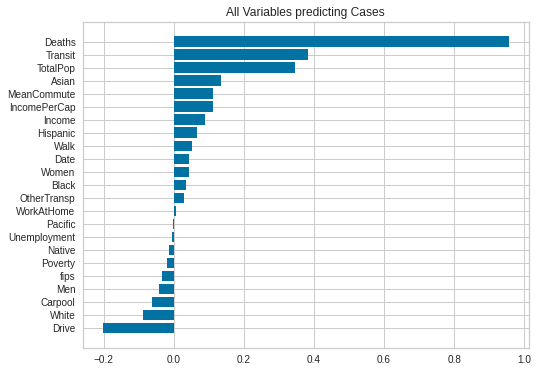

In [132]:
plt.subplots(figsize=(8, 6)) #make the plot larger so we can actually see it
plt.title("All Variables predicting Cases")

visualizer = FeatureCorrelation(labels=features, sort=True)
visualizer.fit(independ, y)        # Fit the data to the visualizer

From this visualization of the correlation of each independent variable, we can draw a few preliminary points, some obvious and some quite interesting:

* Number of reported deaths has an obvious correlation to number of cases, as you will need to first contract the virus for this to take place.
* The population of a county has a high correlation to the number of cases within it. This makes logical sense based on how viruses spread in human populations.
* There is a slight corelation between Date and number of Cases. For the most part, this makes sense in that there is a correlation due to the general spread of the virus, along with its weakness, as there are still many counties who have few or even no reported cases
* Different sociological collected by the Census appear to have very interesting trends, so we will look into each of these similar groups further.

Now that we have a general sense of what we're looking at, let's make some individual groups of related variables and see what we can get.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bdd1c668>,
                   feature_index=None, feature_names=None,
                   labels=array(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific'],
      dtype='<U8'),
                   method='pearson', sort=True)

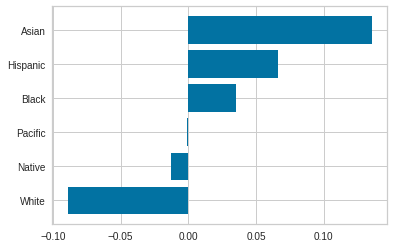

In [133]:
#start off with the ethnicity variables
#NOTE: the order here is not important, it simply follows the order of the Census
ethnicity = np.array(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific'])

indEthnic = independ.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women',
       'Income', 'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'])

visualizer = FeatureCorrelation(labels=ethnicity, sort=True)

visualizer.fit(indEthnic, y)

First off is our analysis between the ethnic makeup of counties and its correlation to number of cases. This is a particularly important subject when looking at this dataset, as many across the country have cited evidence that non-White communities are disproportionately affected by the virus.

From what we see above, our analysis would support this claim. There is a definitive correlation between the Asian population of a county and its number of cases, along with less strong positive correlations for both Hispanic and Black populations. Contrarily, there is a slight negative trend with Native American percentage and a strong negative trend for percentage White. There does not appear to be a correaltion with Pacific Islander population.

These trends are very important, as it would support the claims that several non-White groups are noticeably affected more than the White population, suggesting that underlying sociological issues are at play here. Therefore, this suggests that more work should be done to address this issue, and further analysis is necessary to understand what is taking place.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bdce2240>,
                   feature_index=None, feature_names=None,
                   labels=array(['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute'], dtype='<U11'),
                   method='pearson', sort=True)

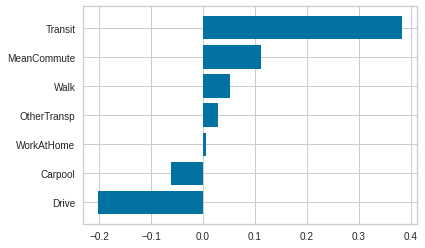

In [134]:
#now work and commute related
commute = np.array(['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute'])

indCommute = independ.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Unemployment'])

visualizer = FeatureCorrelation(labels=commute, sort=True)

visualizer.fit(indCommute, y)

Next is our analysis of typical commuting-related variables within the Census.  
  
Here, there is a clear trend where counties with more users of public transit have a higher number of cases, whereas counties that have a population that primarily drives to work have a negative correlation with number of cases. The other variables here also directly support the claim that more urban cities, where people have the option to use transit or walk and opt to not drive, typically have more cases than less densely population counties. This makes logical sense, as these forms of commuting would lead to more exposure to other potentially infected people, whereas driving alone keeps you isolated.

Oddly enough, it does not appear that the "Work from Home" statistic appears to have had much of an effect on the model. This may be due to the fact that this variable is universally very low, but is interesting in the fact that this is one of the primary parts of social distancing strategies employed across the country.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bdc6c940>,
                   feature_index=None, feature_names=None,
                   labels=array(['Income', 'IncomePerCap', 'Poverty', 'Unemployment'], dtype='<U12'),
                   method='pearson', sort=True)

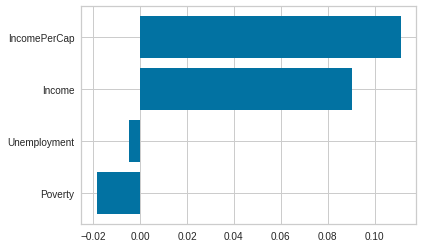

In [135]:
#economic variables
econ = np.array(['Income', 'IncomePerCap', 'Poverty', 'Unemployment'])

indEcon = independ.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute'])

visualizer = FeatureCorrelation(labels=econ, sort=True)

visualizer.fit(indEcon, y)

Here, we check for correlation between number of cases and the economic variables taken by the Census: Income per Capita, Average Income, the Unemployement rate and the Poverty Rate.  

Interestingly, there seems to be a correlation where more wealthy counties tend to have more cases, whereas counties with a higher level of poverty seem to have less. This could also be caused by an urban/rural divide, where wealth tends to be concentrated around larger cities in the US. However, this does not account for cities that may be poorer or wealthy rural communities. 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bdc2c390>,
                   feature_index=None, feature_names=None,
                   labels=array(['TotalPop', 'Men', 'Women'], dtype='<U8'),
                   method='pearson', sort=True)

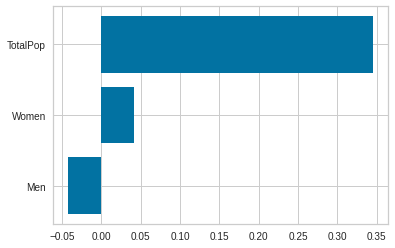

In [136]:
#general geographic variables
general = np.array(['TotalPop', 'Men', 'Women'])

indGen = independ.drop(columns=['Date', 'fips', 'Deaths', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'])

visualizer = FeatureCorrelation(labels=general, sort=True)

visualizer.fit(indGen, y)

Lastly, we check the remaining general census variables of Population, percentage Female and percentage Male.
   
Unsurprisingly once again, there is a clear correlation between population and number of cases, suggesting that a more populous county will have more cases.  
  
On the other hand, there seems to be a slight positive correlation between cases and counties with a higher percentage of women, while naturally there exists and inverse of this trend with men. This would support the claim that women may be disproportionately affect by the virus.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02c108c5c0>,
                   feature_index=None, feature_names=None,
                   labels=array(['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'St...
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'], dtype=object),
                   method='pearson', sort=True)

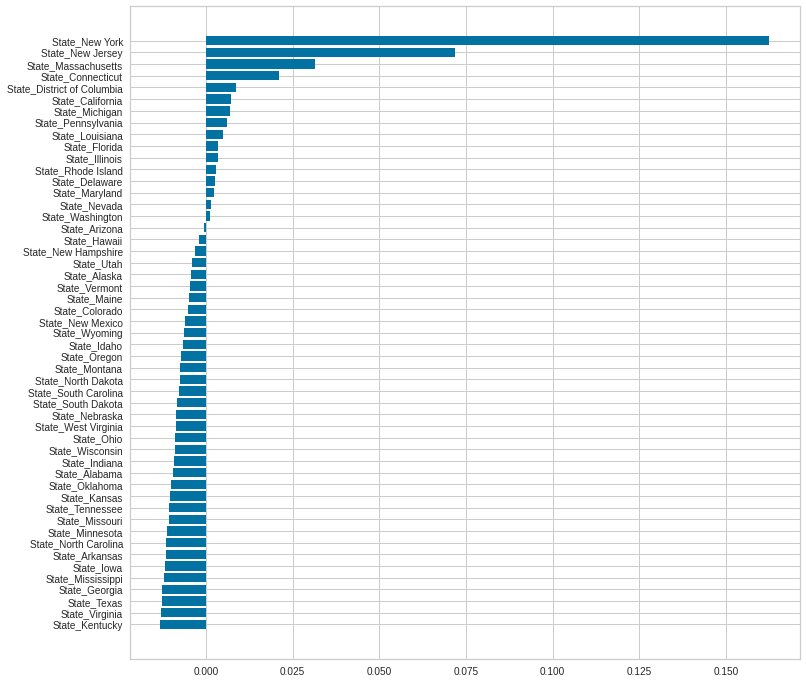

In [137]:
#lastly, state, which is its own style of analysis
features = np.array(covid.columns)
features = np.delete(features, [3]) #remove counts from this, since it's the dependent var
features = np.delete(features, [0]) #remove county since it is not currently included
features = np.delete(features, np.s_[:23]) #delete everyting BUT states

states = X.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'])

plt.subplots(figsize=(12, 12))
visualizer = FeatureCorrelation(labels=features, sort=True)

visualizer.fit(states, y)        # Fit the data to the visualizer

Unlike before, we cannot make simple assumptions about state data, as each state has quiet unique factors within itself that may lead to different trends, including population, density, level of international connectivity, along with the underlying issue of different levels of reaction to the virus. However, we can draw a few very general trends from this information:

* States that are the most affected by the virus naturally have a much higher correlation to number of cases than others, this being primarily New York and New Jersey, both of which are located within the worst outbreak in the county.

* Correlation does not match up exactly to where more populous states have a higher correlation. We can see this through some of the largest states, such as Texas, Georgia, and Virginia, all being located near the bottom of the above graph.

With all of this information, we will now attempt to find larger treds within the data by aggregating it in several different ways. This will give us further insight into some of the tredns we just saw.

##Macro Trends

The previous individual variable analysis provided us interesting information on what does and does not matter in building a model predicting cases, along with telling us a little about the nature of this pandemic. Now, we will attempt to discover any new trneds by aggregating the data in a few different ways. This will hopefully highlight a few interesting points, along with giving us further insight into the previous claims. 

First up will be our analysis of the data relative to each state consisting of all of its counties combined. 

In [139]:
#we will be using the non-encoded version of the dataset we made awhile back
#NOTE: this will only be cases on the most recent date- we will include time aggregations later
#In addition to this, a few less significant variables will be left out

states = nonEncoded
states['Date'] = pd.to_datetime(states['Date']) 

#remove all dates that aren't yesterday
selected_date = pd.date_range(today - pd.to_timedelta(1, unit='d'), today, freq='D')
states = states[states["Date"].isin(selected_date)]

stateCases = states.groupby("State")['Cases'].sum()
stateDeath = states.groupby("State")['Deaths'].sum()
statePop = states.groupby("State")['TotalPop'].sum()
stateMen = states.groupby("State")['Men'].mean()
stateWomen = states.groupby("State")['Women'].mean()
stateHispanic = states.groupby("State")['Hispanic'].mean()
stateWhite = states.groupby("State")['White'].mean()
stateBlack = states.groupby("State")['Black'].mean()
stateNative = states.groupby("State")['Native'].mean()
stateAsian = states.groupby("State")['Asian'].mean()
statePacific = states.groupby("State")['Pacific'].mean()
stateIncomeCap = states.groupby("State")['IncomePerCap'].mean()
statePoverty = states.groupby("State")['Poverty'].mean()
stateTransit = states.groupby("State")['Transit'].mean()
stateDrive = states.groupby("State")['Drive'].mean()

#now put them all back together
stateCases = stateCases.to_frame()
allStates = stateCases.merge(stateDeath, left_index=True, right_index=True)
allStates = allStates.merge(statePop, left_index=True, right_index=True)
allStates = allStates.merge(stateMen, left_index=True, right_index=True)
allStates = allStates.merge(stateWomen, left_index=True, right_index=True)
allStates = allStates.merge(stateHispanic, left_index=True, right_index=True)
allStates = allStates.merge(stateWhite, left_index=True, right_index=True)
allStates = allStates.merge(stateBlack, left_index=True, right_index=True)
allStates = allStates.merge(stateNative, left_index=True, right_index=True)
allStates = allStates.merge(stateAsian, left_index=True, right_index=True)
allStates = allStates.merge(statePacific, left_index=True, right_index=True)
allStates = allStates.merge(stateIncomeCap, left_index=True, right_index=True)
allStates = allStates.merge(statePoverty, left_index=True, right_index=True)
allStates = allStates.merge(stateTransit, left_index=True, right_index=True)
allStates = allStates.merge(stateDrive, left_index=True, right_index=True)

allStates

,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,IncomePerCap,Poverty,Transit,Drive
State,,,,,,,,,,,,,,,
Alabama,4903.0,160.0,4850771.0,0.487016,0.512984,3.298507,65.168657,28.673134,0.607463,0.711940,0.017910,22180.492537,20.949254,0.220896,85.488060
Alaska,163.0,3.0,738565.0,0.538550,0.461450,5.093103,48.420690,1.179310,31.627586,5.982759,0.544828,31670.551724,13.555172,1.075862,47.024138
Arizona,4929.0,188.0,6809946.0,0.504501,0.495499,30.886667,50.826667,1.813333,13.233333,1.293333,0.126667,22712.200000,20.193333,0.973333,77.526667
Arkansas,1735.0,39.0,2977944.0,0.494146,0.505854,5.090667,75.634667,16.132000,0.540000,0.692000,0.077333,21449.306667,20.421333,0.286667,81.816000
California,31514.0,1175.0,38832664.0,0.505430,0.494570,29.656140,55.142105,2.892982,1.664912,7.131579,0.292982,30602.122807,15.647368,2.968421,73.503509
Colorado,9616.0,420.0,5436519.0,0.517922,0.482078,20.037500,74.657813,1.482812,0.831250,1.109375,0.114062,29647.046875,13.234375,1.595312,71.737500
Connecticut,17433.0,1123.0,3594478.0,0.492206,0.507794,11.425000,76.037500,6.475000,0.125000,3.575000,0.000000,39419.125000,9.200000,3.112500,80.050000
Delaware,2508.0,67.0,943732.0,0.483901,0.516099,8.533333,65.366667,20.100000,0.400000,2.866667,0.000000,31278.333333,12.300000,1.966667,82.000000
District of Columbia,2793.0,96.0,672391.0,0.474495,0.525505,10.700000,36.000000,46.900000,0.200000,3.700000,0.000000,50832.000000,17.400000,35.400000,34.000000


Now that we have a state-related dataset, we can build a new linear regression model centered around this, along with similar correlations comparisons to what we had before.

In [142]:
states.isna().any()

County          False
Date            False
State           False
fips            False
Cases           False
Deaths          False
TotalPop        False
Men             False
Women           False
Hispanic        False
White           False
Black           False
Native          False
Asian           False
Pacific         False
Income          False
IncomePerCap    False
Poverty         False
Drive           False
Carpool         False
Transit         False
Walk            False
OtherTransp     False
WorkAtHome      False
MeanCommute     False
Unemployment    False
dtype: bool

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = allStates.loc[:, allStates.columns != 'Cases']

y = allStates['Cases']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)


In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [149]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.987765983255845
0.9652480586588148


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bbbf2198>,
                   feature_index=None, feature_names=None,
                   labels=array(['Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'IncomePerCap', 'Poverty', 'Transit',
       'Drive'], dtype=object),
                   method='pearson', sort=True)

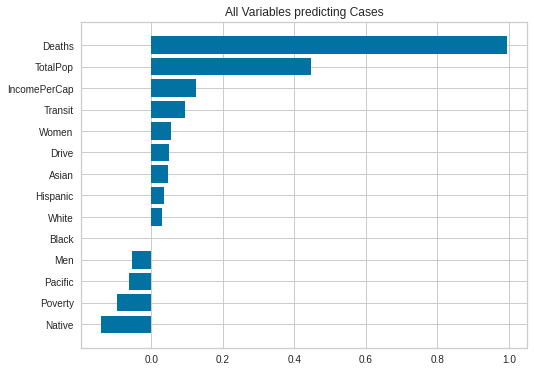

In [150]:
#isolate out the names of the independent vars
features = np.array(X.columns)

plt.subplots(figsize=(8, 6)) #make the plot larger so we can actually see it
plt.title("All Variables predicting Cases")

visualizer = FeatureCorrelation(labels=features, sort=True)
visualizer.fit(X, y)        # Fit the data to the visualizer

Our state model has provided us with support for a few key ideas, while also challenging other concepts that we have seen. Interestingly, our state-only model seems to be much more accurate than the regular county-based model, despite having significantly less data points to train on. However, the lack of variety the state data has in comparison to the huge number of counties likely explains this fact.

For the most part, the highly correlating variables from before still hold to be important here: Deaths, Total Population, Income per Capita, and Transit usage all appear to be quite important to the model. However, what is interesting is the changes of a few variables from positive to negative and vice versa. For example, Percentage Women is now positively correlated, while Percentage Men is negatively correlated. Additionally, the general statistics upon ethnicity have changed. Although the most highly correlated categories from before (Asian, Hispanic) remain the same, the others are quite different, where White is now a positive correlation, Native quite negative, and Black now has little to no correlation at all.

Naturally, the changes above are caused by the differences in demographics between states and their individual counties- a state may have a diverse metropolitan area and be primarily rural outside of that, a state may be largely one ethnic group and have few to no urban area, etc. Ideally, a curious reader of this project could use both models and potentially make educated guesses on their own area based on both their state and neighboring counties.

After states, we will now look at different periods of time to look for any other unique trends.

In [0]:
#have fun aggregating this. May the god of Timeseries have mercy on your pitiful soul

##A few more Models

The dataset still lends us to a few more models that predict variables other than Number of cases. Ideally, these models will show completely new insight into the datta that we had never seen before.

To start off, the logical first step would be to predict Deaths, using a linear model quite like before.

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Deaths']

#once again we will be leaving counties out for the moment, as it is more of an identifier than a variable
counties = regression['County']
X = X.loc[:, X.columns != 'County']

y = regression['Deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [159]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.9148716562138568
0.9495693008836867


Our model appears to be ever so slightly less accurate than our original, although still very accurate. This indicates to us that Census data is useful for predicting both cases and deaths. However, as always, let us look at the individual variables to see if anything is different.

In [0]:
#fix up X as needed
independ = X.drop(columns=['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bd4da048>,
                   feature_index=None, feature_names=None,
                   labels=array(['Date', 'fips', 'Cases', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'],
      dtype=object),
                   method='pearson', sort=True)

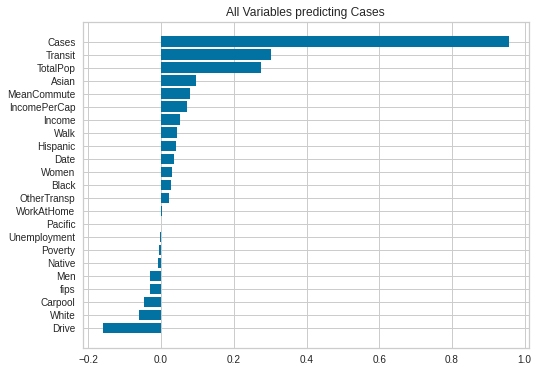

In [161]:
#isolate out the names of the independent vars
features = np.array(independ.columns)

plt.subplots(figsize=(8, 6)) #make the plot larger so we can actually see it
plt.title("All Variables predicting Cases")

visualizer = FeatureCorrelation(labels=features, sort=True)
visualizer.fit(independ, y)        # Fit the data to the visualizer

Unsurprisingly, there seems to be virtually no change in the correlation of variables between Cases and Deaths. This suggests that Cases and Deaths are largely tied together, once again making logical sense based on the nature of the virus.

Next, we will explore the standard linear model predicting Cases, albeit without deaths. Since Deaths and Cases are so clearly tied together, let us check to see if our model is still useful without this variable.

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Cases']

#once again we will be leaving counties out for the moment, as it is more of an identifier than a variable
counties = regression['County']
X = X.loc[:, X.columns != 'County']

#leaving out deaths, since that's the entire purpose of this part
X = X.loc[:, X.columns != 'Deaths']

y = regression['Cases']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [164]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.2609108988753738
0.28452599596641814


Alright, so as expected, Deaths clearly plays a significant role in this model in aiding to predict number of cases- the accuracy of our model has dropped substantially. From the above information, we can estimate that our Census variables provide us with a little over a quarter of all accuracy. Although this may seem problematic, it is to be expected- there is (at the time of this project) no way to perfectly  predict the spread of the virus without knowing information about the virus itself. In addition, this does not mean our model is without use- we still have access to current data for both cases and deaths. Which leads us to our next model...

From here, we will try something new- using an ARIMA model to extrapolate (in a controlled way) our data and make predictions for the future. 

ARIMA time series analysis, once again may not be applicable

Predicting date, which is quite interesting

##Visualization

#Conclusion

##Last Model

##Summary